https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes

Title:
Predict car price

# Dataset Description:
- 100k listings for 
- 8 makes, 196 models for petrol, diesel and hybrid cars


EDA findings:
 - dropped MPG

 - define a good values for predictionasd
 - found similar cars by groupping same makes, models, year build and mileage rounded to nearst 10k and 5k
  - compare MAE and S values of ground trooth data to values prediucted by model

Feature Engineering:
 - none ?

Model:
- create one model for each make, model and engine type, using maily mileager and year as features

- explore building single mdoel for make
- explroe building single model for all cars

# Setup and Imports

In [1]:
import sys
if '../Toolkit' not in sys.path: sys.path.append('../Toolkit')

%load_ext autoreload
%autoreload 1

%aimport tools
%aimport models

import tools as t
import models as m

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.display import clear_output

import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 113
import matplotlib.pyplot as plt
import seaborn as sns

RS = 35577 # global random state seed
raw_data_path = 'data-raw'
processed_data_path = 'data-processed'

In [8]:
from pathlib import Path

# Transformations

In [60]:
df_data.drop_duplicates(inplace=True)
df_data['model'] = df_data['model'].str.strip()

drop_cars_transmission_other = lambda df: df.drop(df.loc[df['transmission'] =='Other'].index)
drop_other_electric_fuel_types = lambda df: df.drop(df.loc[df['fuelType'].isin(['Other', 'Electric'])].index)
drop_bmw_i3 = lambda df: df.drop(df.loc[df['model'] == 'i3'].index)
drop_engine_size_0 = lambda df: df.drop(df.loc[df['engineSize'] == 0].index)
drop_cars_older_1990_and_from_future = lambda df : df.drop(df.loc[ (df['year'] < 1990) | (2022 < df['year']) ].index)

drop_mpg_tax = lambda df: df.drop(columns=['mpg', 'tax'])

# Select and Merge CSV's

In [4]:
csv_paths = [f for f in Path(f'{raw_data_path}').iterdir()]
csv_paths

[PosixPath('data-raw/audi.csv'),
 PosixPath('data-raw/bmw.csv'),
 PosixPath('data-raw/cclass.csv'),
 PosixPath('data-raw/focus.csv'),
 PosixPath('data-raw/ford.csv'),
 PosixPath('data-raw/hyundi.csv'),
 PosixPath('data-raw/merc.csv'),
 PosixPath('data-raw/skoda.csv'),
 PosixPath('data-raw/toyota.csv'),
 PosixPath('data-raw/unclean cclass.csv'),
 PosixPath('data-raw/unclean focus.csv'),
 PosixPath('data-raw/vauxhall.csv'),
 PosixPath('data-raw/vw.csv')]

In [6]:
all_series = []
for c_p in csv_paths:
    df = pd.read_csv(c_p)
    s = (~df.isna()).sum()
    s.name = c_p.name
    all_series.append(s)
    
df_all_desc = pd.concat(all_series, axis=1).fillna(0)
df_all_desc.style.background_gradient(cmap = 'Greens', vmin=-1000).format('{:.0f}')

df_all_desc.columns

,audi.csv,bmw.csv,cclass.csv,focus.csv,ford.csv,hyundi.csv,merc.csv,skoda.csv,toyota.csv,unclean cclass.csv,unclean focus.csv,vauxhall.csv,vw.csv
model,10668,10781,3899,5454,17965,4860,13119,6267,6738,3907,5548,13632,15157
year,10668,10781,3899,5454,17965,4860,13119,6267,6738,3904,5459,13632,15157
price,10668,10781,3899,5454,17965,4860,13119,6267,6738,3907,5548,13632,15157
transmission,10668,10781,3899,5454,17965,4860,13119,6267,6738,3907,5548,13632,15157
mileage,10668,10781,3899,5454,17965,4860,13119,6267,6738,3808,4729,13632,15157
fuelType,10668,10781,3899,5454,17965,4860,13119,6267,6738,0,0,13632,15157
tax,10668,10781,0,0,17965,0,13119,6267,6738,0,0,13632,15157
mpg,10668,10781,0,0,17965,4860,13119,6267,6738,0,0,13632,15157
engineSize,10668,10781,3899,5454,17965,4860,13119,6267,6738,0,0,13632,15157
tax(£),0,0,0,0,0,4860,0,0,0,0,0,0,0


Index(['audi.csv', 'bmw.csv', 'cclass.csv', 'focus.csv', 'ford.csv',
       'hyundi.csv', 'merc.csv', 'skoda.csv', 'toyota.csv',
       'unclean cclass.csv', 'unclean focus.csv', 'vauxhall.csv', 'vw.csv'],
      dtype='object')

In [12]:
csv_names = ['audi.csv', 'bmw.csv', 'ford.csv', 'hyundi.csv', 'merc.csv', 'skoda.csv', 'toyota.csv', 'vauxhall.csv', 'vw.csv']

all_dfs = []
for csv_name in csv_names:
    df_path = f'{raw_data_path}/{csv_name}'
    df = pd.read_csv(f'{raw_data_path}/{csv_name}')
    if 'tax(£)' in df.columns:
        df.rename(columns={"tax(£)": "tax"}, inplace=True)
    df.insert(0, 'make', csv_name[:-4].title())
    all_dfs.append(df)
    
df_data = pd.concat(all_dfs, axis=0, ignore_index=True)


# Preliminary analysis

In [13]:
'df has duplives: ', df_data.duplicated().sum()

('df has duplives: ', 1475)

In [14]:
df_data.info()
df_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99187 entries, 0 to 99186
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   make          99187 non-null  object 
 1   model         99187 non-null  object 
 2   year          99187 non-null  int64  
 3   price         99187 non-null  int64  
 4   transmission  99187 non-null  object 
 5   mileage       99187 non-null  int64  
 6   fuelType      99187 non-null  object 
 7   tax           99187 non-null  int64  
 8   mpg           99187 non-null  float64
 9   engineSize    99187 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 7.6+ MB


,year,price,mileage,tax,mpg,engineSize
count,99187.000000,99187.000000,99187.000000,99187.000000,99187.000000,99187.000000
mean,2017.087723,16805.347656,23058.914213,120.299838,55.166825,1.663280
std,2.123934,9866.773417,21148.523721,63.150926,16.138522,0.557646
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,9999.000000,7425.000000,125.000000,47.100000,1.200000
50%,2017.000000,14495.000000,17460.000000,145.000000,54.300000,1.600000
75%,2019.000000,20870.000000,32339.000000,145.000000,62.800000,2.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


In [16]:
df_data.columns

cat_features = ['make', 'model', 'transmission', 'fuelType']
'cat_features', cat_features

num_features = ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']
'num_features', num_features

len(cat_features + num_features) == len(df.columns)

Index(['make', 'model', 'year', 'price', 'transmission', 'mileage', 'fuelType',
       'tax', 'mpg', 'engineSize'],
      dtype='object')

('cat_features', ['make', 'model', 'transmission', 'fuelType'])

('num_features', ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize'])

True

### Remove whitespaces from model

In [11]:
df_data['model'] = df_data['model'].str.strip()
df_data.drop_duplicates(inplace=True)
df_data.duplicated().sum()

# Visualise the Data

## Categorical Features

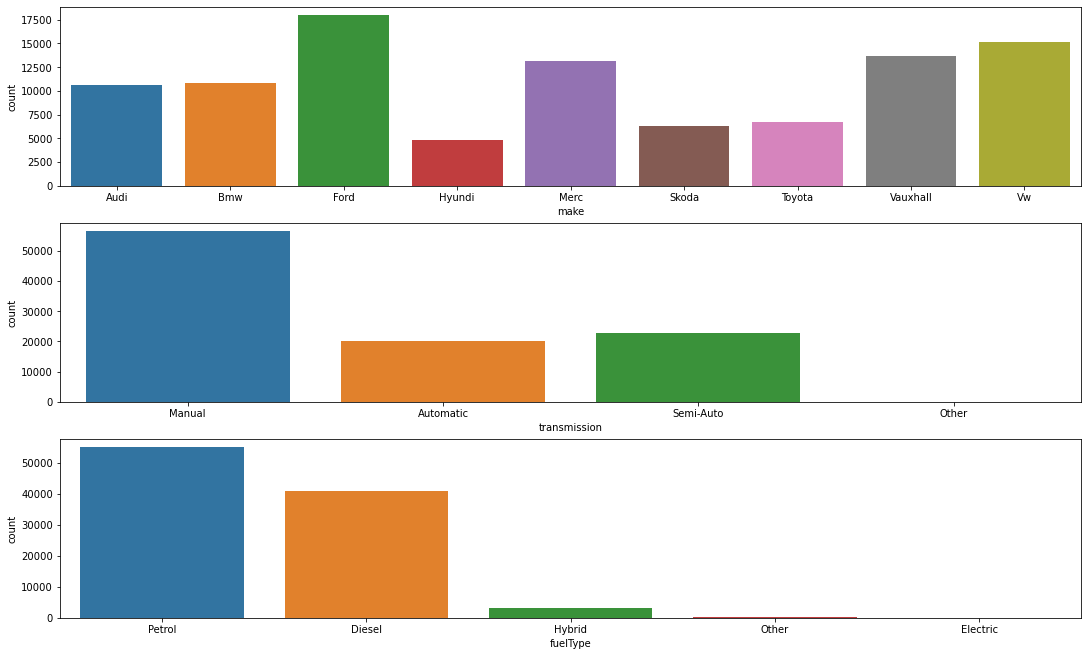

In [21]:
axs = t.get_axes(3, 1, 0.2)
for col, ax in zip(['make', 'transmission', 'fuelType'], axs.flat):
    _ = sns.countplot(ax=ax, data=df_data, x=col)

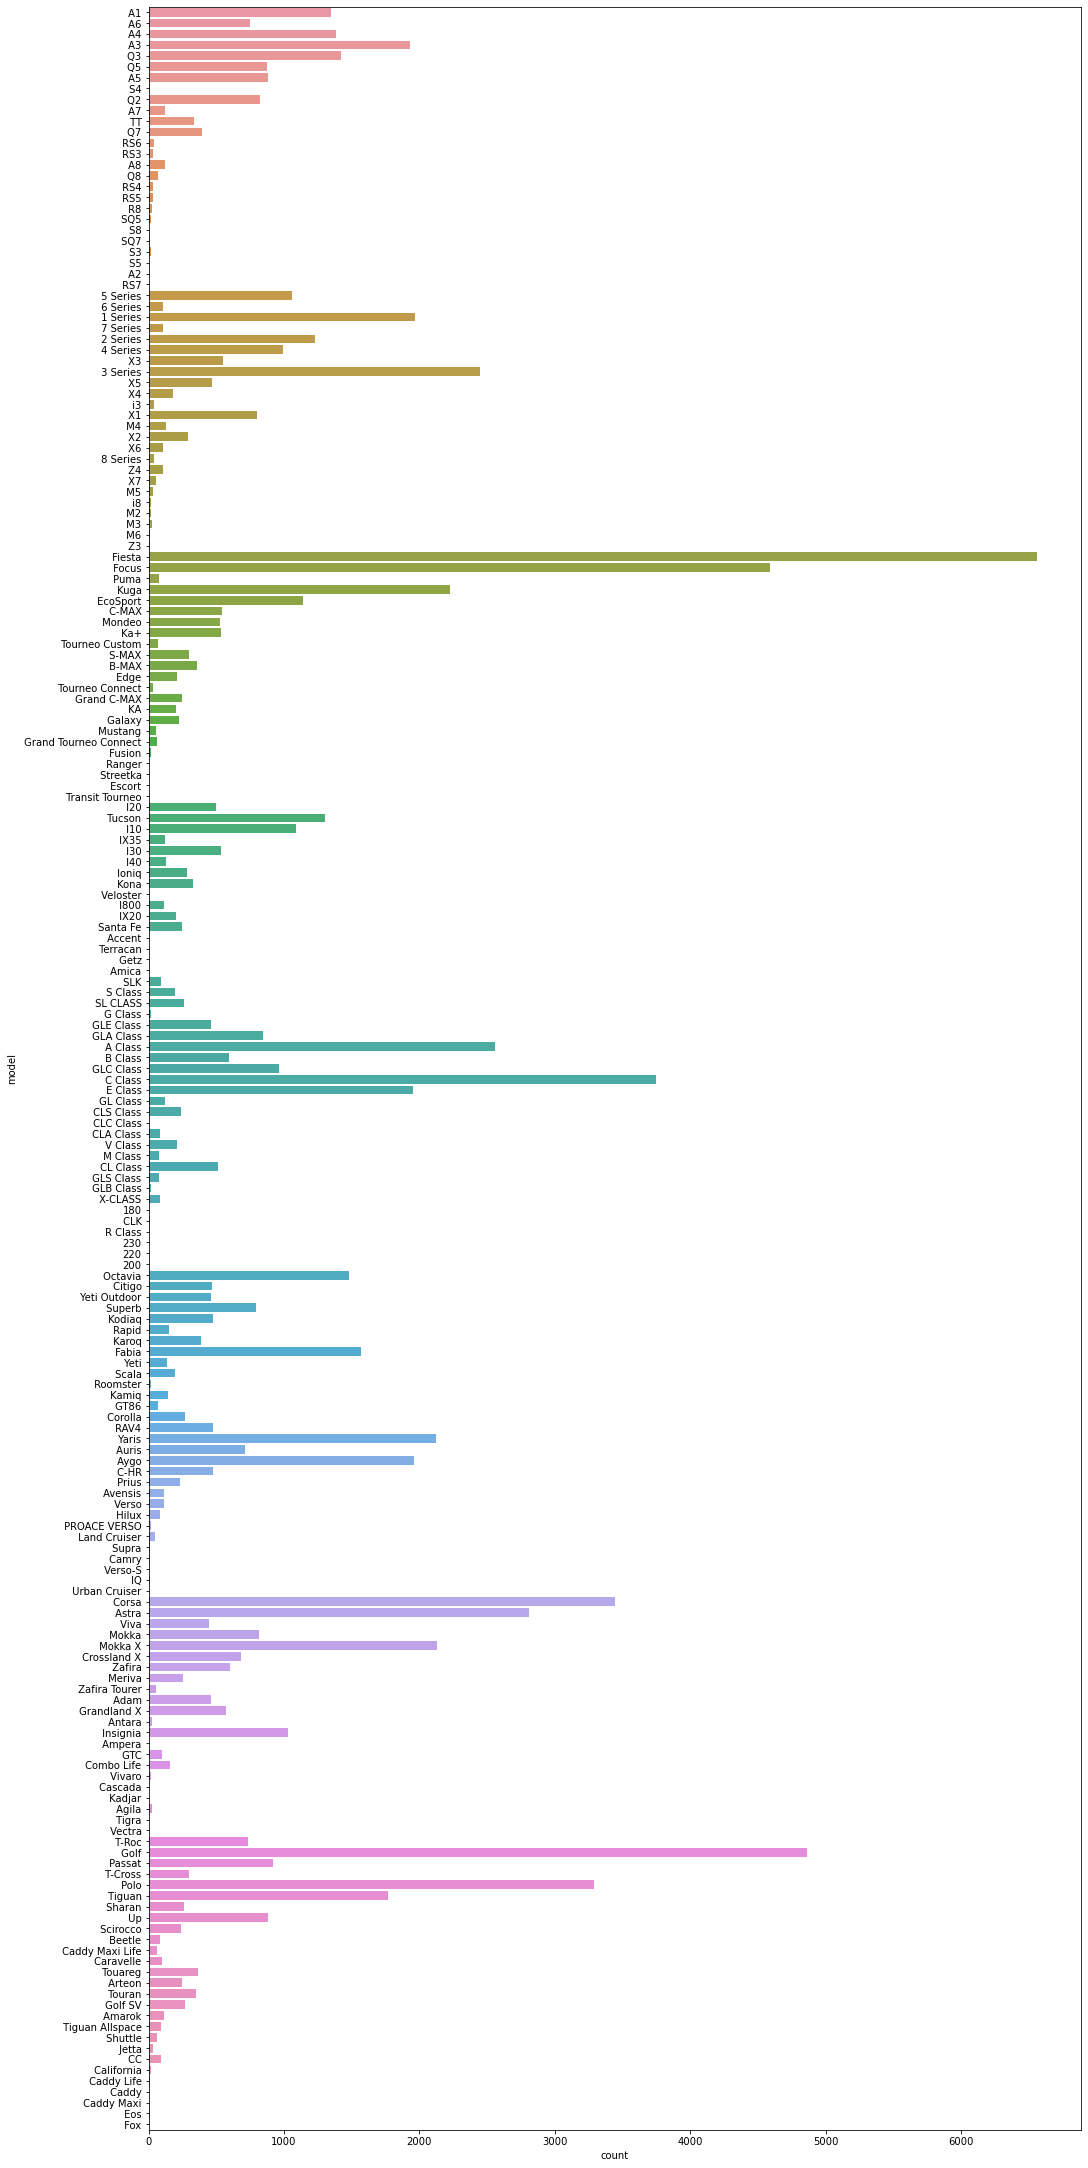

In [30]:
ax = t.get_ax(2)
_ = sns.countplot(ax=ax, data=df_data, y='model')

In [54]:
df_transmission_other = df_data.loc[df_data['transmission'] =='Other']
len(df_transmission_other)
df_transmission_other

0

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize


In [52]:
df_fule_type_other = df_data.loc[df_data['fuelType'] == 'Other']
len(df_fule_type_other)
df_fule_type_other.head(5)

0

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize


In [53]:
df_fule_type_electric = df_data.loc[df_data['fuelType'] == 'Electric']
len(df_fule_type_electric)
df_fule_type_electric.head(5)

0

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize


In [51]:
df_data = drop_other_electric_fuel_types(df_data)
df_data = drop_cars_transmission_other(df_data)

## Numeric - Discreet

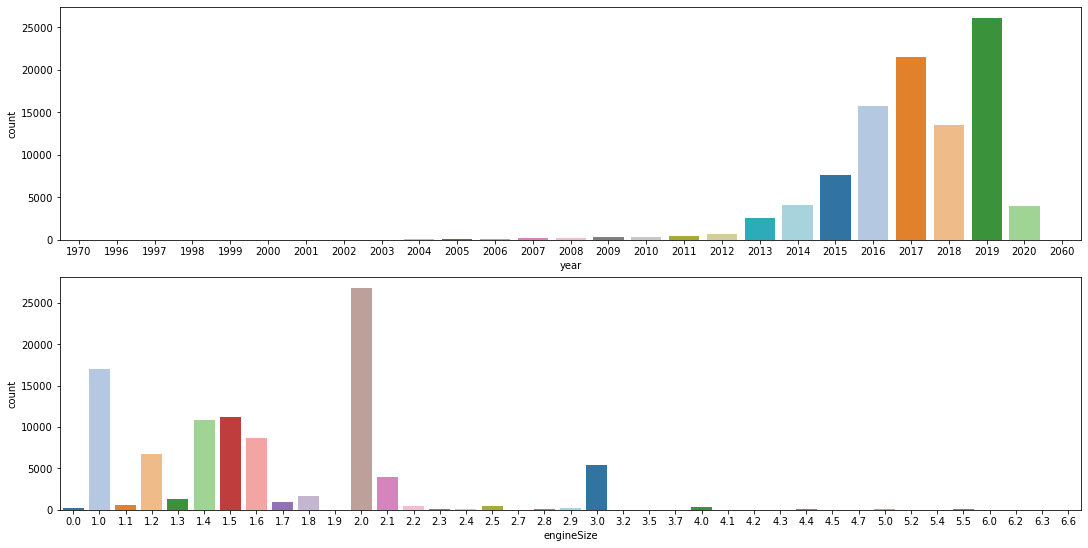

In [55]:
axs = t.get_axes(2, 1, 0.25).flat
_ = sns.countplot(ax=axs[0], x = df_data.year, palette=plt.cm.tab20.colors)

_ = sns.countplot(ax=axs[1], x = df_data.engineSize, palette=plt.cm.tab20.colors)

In [64]:
df_engineSize_0 = df_data.loc[df_data['engineSize'] == 0]
len(df_engineSize_0)
df_engineSize_0['model'].value_counts(normalize=True)

0

Series([], Name: model, dtype: float64)

In [63]:
df_bmw_i3 = df_data.loc[df_data['model'] == 'i3']
len(df_bmw_i3)
df_bmw_i3.head()

0

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize


In [61]:
df_data = drop_bmw_i3(df_data)
df_data = drop_engine_size_0(df_data)

## Numeric - Continuous

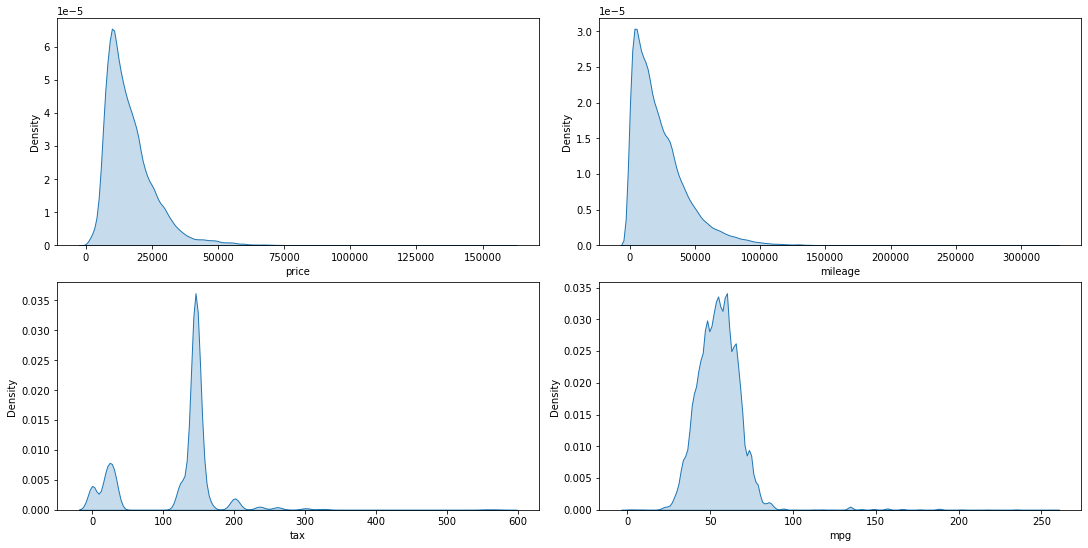

In [65]:
axs = t.get_axes(2, 2, 0.5)

for col, ax in zip(['price', 'mileage', 'tax', 'mpg'], axs.flat):
    _ = sns.kdeplot(ax=ax, data=df_data, x=col, shade=True)

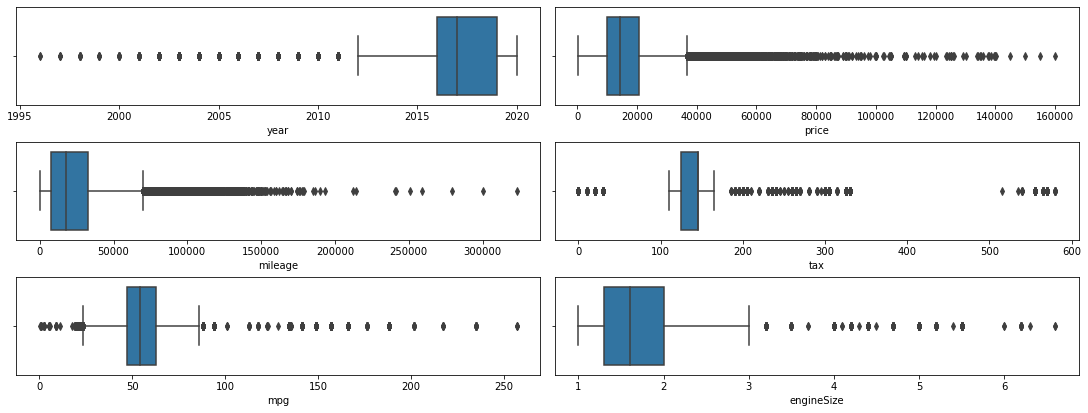

In [73]:
axs = t.get_axes(3, 2, 0.25)

for col, ax in zip(num_features, axs.flat):
    _ = sns.boxplot(ax=ax, x=df_data[col], orient='w')
    # ax.axes.get_yaxis().set_visible(False)

In [72]:
df_data.sort_values(by=['year']).head(5)
df_data.sort_values(by=['year']).tail(5)

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
38327,Ford,Escort,1996,3000,Manual,50000,Petrol,265,34.4,1.8
20293,Bmw,5 Series,1996,5995,Automatic,36000,Petrol,270,26.4,2.8
56186,Merc,SL CLASS,1997,9995,Automatic,76000,Petrol,255,28.2,3.2
76255,Vauxhall,Astra,1997,950,Manual,89233,Petrol,265,35.8,1.6
20509,Bmw,Z3,1997,3950,Manual,49000,Petrol,270,35.3,1.9


,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
7276,Audi,Q7,2020,49989,Semi-Auto,6000,Diesel,145,33.2,3.0
52509,Merc,CL Class,2020,30389,Semi-Auto,1000,Diesel,145,55.4,2.0
96087,Vw,Sharan,2020,36999,Semi-Auto,250,Petrol,145,32.5,1.4
83877,Vauxhall,Combo Life,2020,16390,Manual,346,Petrol,145,42.2,1.2
33747,Ford,EcoSport,2020,19000,Manual,10,Petrol,145,52.3,1.0


In [71]:
df_data = drop_cars_older_1990_and_from_future(df_data)

In [75]:
df_data.sort_values(by=['price']).head(5)
df_data.sort_values(by=['price']).tail(5)

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
76318,Vauxhall,Astra,2001,450,Manual,159000,Petrol,235,40.4,1.6
84017,Vauxhall,Agila,2003,450,Manual,90000,Petrol,205,43.5,1.2
73656,Vauxhall,Corsa,2002,495,Manual,99842,Petrol,145,50.4,1.0
38552,Ford,Focus,2003,495,Manual,177644,Petrol,200,41.5,1.6
73670,Vauxhall,Corsa,2003,590,Manual,82000,Petrol,160,44.8,1.2


,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
53011,Merc,A Class,2019,140319,Semi-Auto,785,Petrol,150,22.1,4.0
4783,Audi,R8,2020,145000,Semi-Auto,2000,Petrol,145,21.1,5.2
44279,Merc,SL CLASS,2011,149948,Automatic,3000,Petrol,570,21.4,6.2
54318,Merc,G Class,2020,154998,Automatic,3000,Petrol,150,21.4,4.0
50473,Merc,G Class,2020,159999,Semi-Auto,1350,Petrol,145,21.4,4.0


In [76]:
df_data.sort_values(by=['mileage']).head(5)
df_data.sort_values(by=['mileage']).tail(5)

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
92150,Vw,Polo,2020,16990,Manual,1,Petrol,150,50.4,1.0
28379,Ford,Fiesta,2017,10995,Manual,1,Petrol,145,65.7,1.0
42109,Hyundi,I30,2019,27800,Manual,1,Petrol,145,34.0,2.0
97353,Vw,Beetle,2001,899,Automatic,1,Petrol,325,29.7,2.0
82470,Vauxhall,Grandland X,2019,24995,Manual,1,Petrol,145,44.1,1.2


,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
62978,Skoda,Octavia,2010,1485,Manual,250650,Diesel,125,57.6,1.9
55618,Merc,V Class,2010,6949,Automatic,259000,Diesel,540,30.7,3.0
81217,Vauxhall,Zafira,2013,1395,Manual,279000,Diesel,150,55.4,1.7
63462,Skoda,Octavia,2010,1190,Manual,300000,Diesel,125,57.6,1.9
9822,Audi,A6,2008,2490,Manual,323000,Diesel,200,44.1,2.0


In [77]:
df_data.sort_values(by=['mpg']).head(5)
df_data.sort_values(by=['mpg']).tail(5)

,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
98534,Vw,Golf SV,2019,17950,Manual,100,Petrol,145,0.3,1.0
40222,Hyundi,Ioniq,2020,23895,Automatic,4152,Hybrid,135,1.1,1.6
54640,Merc,A Class,2020,33900,Automatic,345,Hybrid,140,1.1,1.3
39624,Hyundi,Ioniq,2019,22998,Automatic,2844,Hybrid,140,1.1,1.6
44220,Hyundi,Ioniq,2020,28995,Automatic,5213,Hybrid,135,1.1,1.6


,make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
69778,Toyota,Prius,2019,24987,Automatic,6552,Hybrid,135,235.0,1.8
69927,Toyota,Prius,2018,19699,Automatic,43678,Hybrid,135,235.0,1.8
41629,Hyundi,Ioniq,2018,18999,Automatic,12045,Hybrid,135,256.8,1.6
41502,Hyundi,Ioniq,2019,19995,Automatic,7386,Hybrid,135,256.8,1.6
40627,Hyundi,Ioniq,2018,18970,Automatic,14886,Hybrid,135,256.8,1.6


In [78]:
df_data = drop_mpg_tax(df_data)

## Pairplot

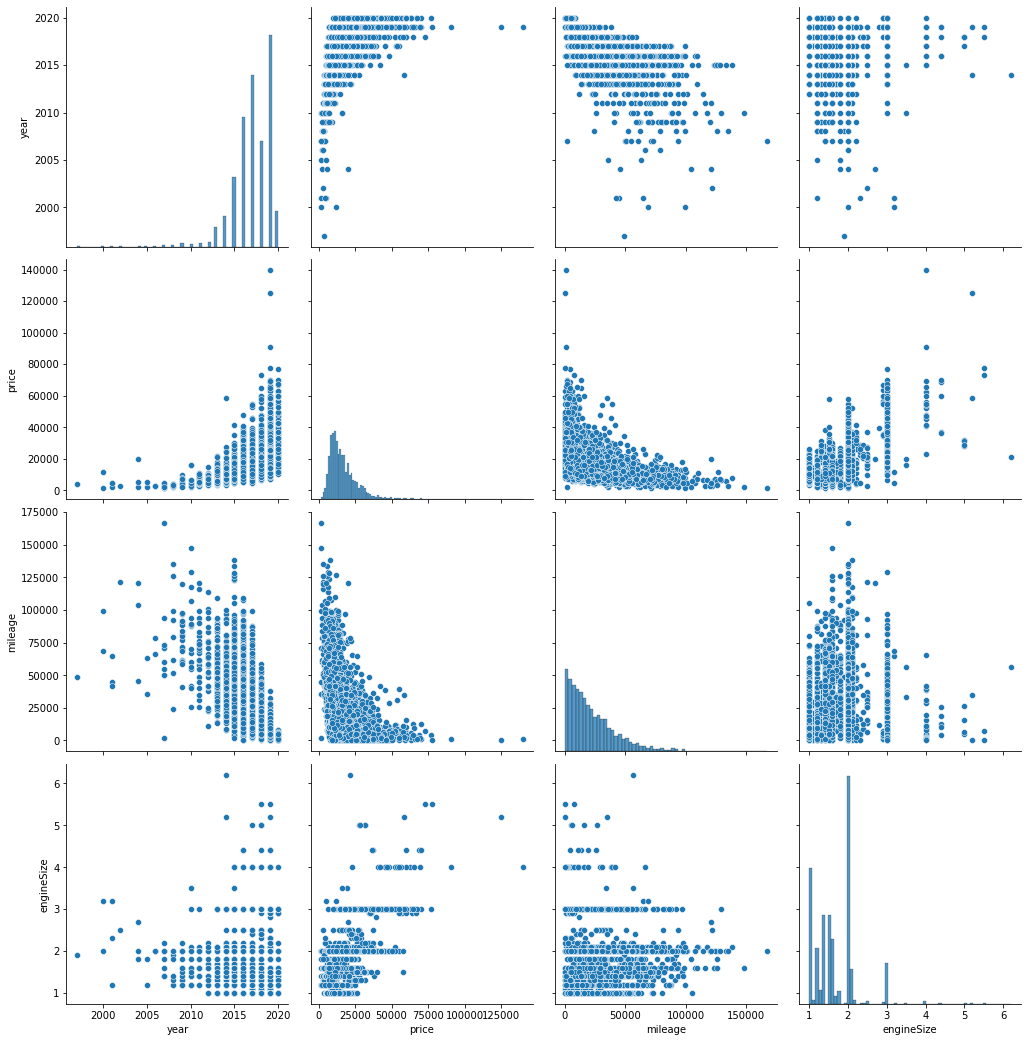

In [79]:
df_plt = df_data.sample(5000, random_state=RS)
_ = sns.pairplot(data=df_plt).fig.set_size_inches(15,15)

## model occurance analysis

In [103]:
car_vc = (df_data['make'] + '__' + df_data['model']).value_counts().sort_values()
car_vc[car_vc <10]
car_vc[car_vc <10].sum()

Series([], dtype: int64)

0

In [101]:
drop_cars_by_name = lambda df, names: df.drop( df.loc[ (df['make'] + '__' + df['model']).isin(names) ].index )

df_data.shape
df_data = drop_cars_by_name(df_data, car_vc[car_vc <10].index.to_list())

## Price analysis

In [121]:
mileage_5k = ((df_data['mileage'] / 5000).round(0) * 5000).astype(int)

df_grp = df_data.drop(columns='mileage').groupby(['make', 'model', 'year', 'transmission', mileage_5k, 'fuelType', 'engineSize'])\
    ['price'].agg([len, np.mean, np.std, m.mad])

4.07665812576133

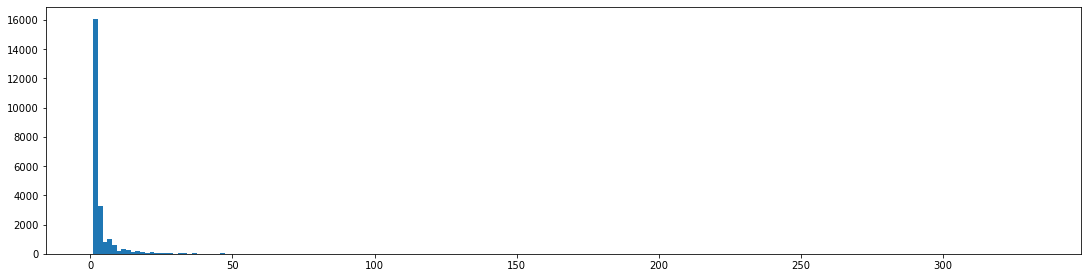

In [134]:
ax = t.get_ax(0.25)
_ = ax.hist(df_grp['len'], bins=200)

df_grp['len'].mean()

In [138]:
df_grp['std'].mean()
df_grp['mad'].mean()

1322.468574588338

482.1781696748918

In [135]:
df_grp['std'].describe()
df_grp['mad'].describe()

count    11654.000000
mean      1322.468575
std       1421.556426
min          0.000000
25%        528.889993
50%        956.013675
75%       1650.776952
max      42744.604923
Name: std, dtype: float64

count    23807.000000
mean       482.178170
std        884.246631
min          0.000000
25%          0.000000
50%          0.000000
75%        696.543333
max      30225.000000
Name: mad, dtype: float64

In [137]:
t.to_pkl(df_data, f'{processed_data_path}/df_clean.pkl')